In [6]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
%matplotlib notebook

In [7]:
def read_metrics(path):
    return h5py.File(Path(path)/"metrics.h5", "r", swmr=True, rdcc_nbytes=1024**3)

In [53]:
def plot_metric(ax, d, name, iqr_ylim=None, legend=True):
    l = np.argmin(d['steps'])
    if l == 0:
        l = len(d['steps'])
    l = min(len(d[name]), l)
    ax.plot(d['steps'][:l], d[name][:l], label=name)
    if legend:
        ax.legend()
    if iqr_ylim is not None:
        all_min, q25, median, q75, all_max = np.nanpercentile(d[name][:l], (0, 25, 50, 75, 100))
        iqr = q75 - q25
        lower = max(median- iqr_ylim*iqr, all_min-0.05*iqr)
        upper = min(median+iqr_ylim*iqr, all_max+0.05*iqr)
        ax.set_ylim((lower, upper))

In [49]:
np.argmin(d['steps']), len(d['steps'])

(214852, 215040)

# VerletSGLD metrics

In [40]:
16 * 1250 / (33*1024)

0.5918560606060606

In [54]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/29")
d.keys()

<KeysViewHDF5 ['acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps', 'total_energy']>

In [55]:
def print_dtypes(d, prefix=""):
    for k, v in d.items():
        if isinstance(v, h5py.Group):
            print_dtypes(v, prefix=k+"/")
        else:
            print(prefix+k, "dtype=", v.dtype, "shape=", v.shape)
#print_dtypes(d)

In [64]:
from bnn_priors.exp_utils import load_samples

samples = load_samples("/scratch/ag919/logs/BNN-priors/4/samples.pt")

In [65]:
samples

{'net.conv1.weight_prior.p': tensor([[[[[-1.4020e-01, -2.1887e-01, -6.6889e-01],
            [ 2.1251e-01,  3.9673e-03,  1.3577e-01],
            [-4.3147e-02,  4.7017e-01,  1.3144e-01]],
 
           [[-3.0959e-01,  3.5095e-01, -7.6408e-02],
            [-4.7111e-01, -4.3671e-01, -6.0343e-02],
            [-4.8911e-01, -5.9432e-01, -2.1023e-01]],
 
           [[ 8.2814e-02, -2.1937e-01, -1.9172e-03],
            [ 1.8751e-01, -1.2762e-01, -1.7858e-01],
            [-2.8928e-01, -3.7027e-02,  2.9074e-01]]],
 
 
          [[[-1.5717e-01,  6.2627e-01, -1.5602e-01],
            [-1.4882e-01,  3.3337e-02, -1.2337e-01],
            [-3.8066e-01,  4.0092e-01, -1.3970e-01]],
 
           [[-1.2199e-01,  1.6029e-01,  4.4809e-02],
            [-2.9851e-01,  5.7492e-01, -2.1875e-01],
            [-4.9455e-01,  2.4758e-01, -3.1125e-01]],
 
           [[ 3.7234e-01,  6.3012e-01, -1.9081e-01],
            [ 3.3018e-01, -1.2714e-01, -6.5832e-01],
            [ 3.4004e-01,  7.7966e-02,  1.1792e-01]]]

<IPython.core.display.Javascript object>


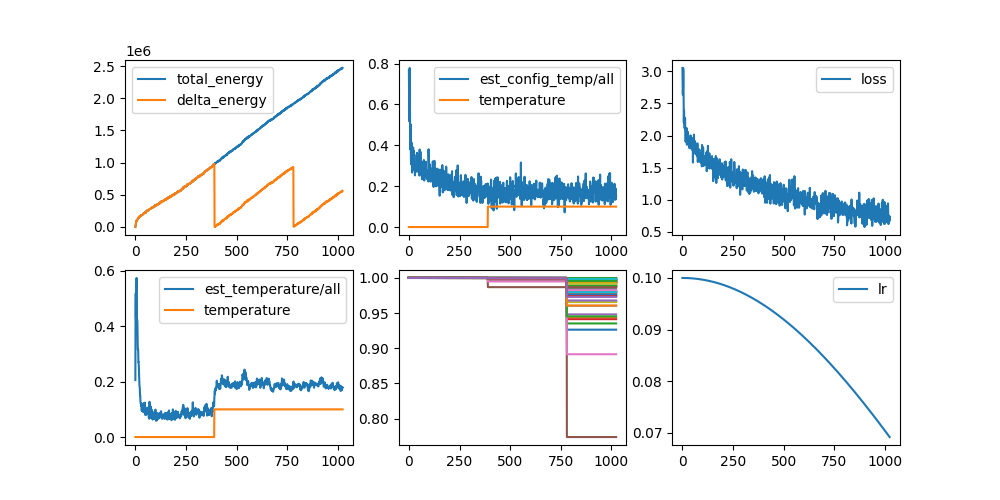

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plot_metric(axes[0, 0], d, 'total_energy')
plot_metric(axes[0, 0], d, 'delta_energy')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'lr')

fig.show()

In [85]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/6")
d.keys()

<KeysViewHDF5 ['delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps', 'total_energy']>

<IPython.core.display.Javascript object>


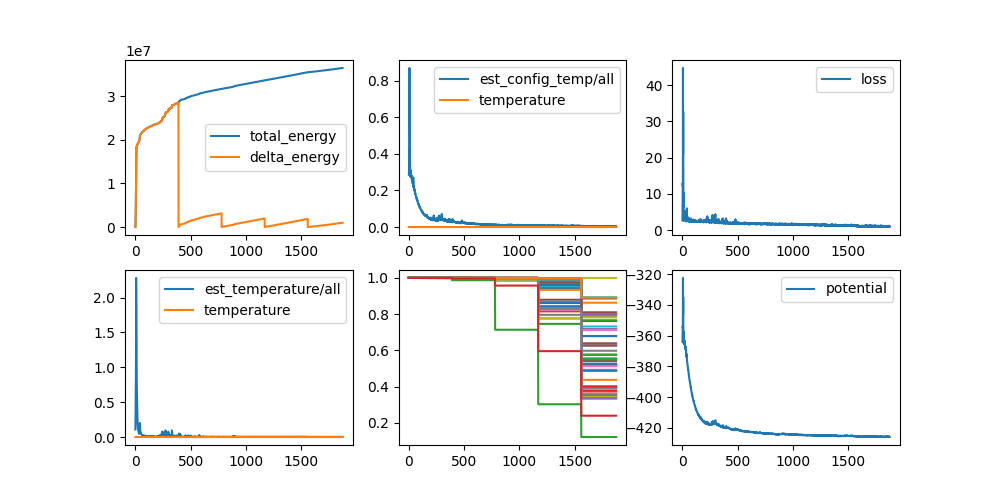

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plot_metric(axes[0, 0], d, 'total_energy')
plot_metric(axes[0, 0], d, 'delta_energy')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'potential')

fig.show()

In [81]:
idx = (d['lr'][:] == np.nanmin(d['lr']))
idx, = np.where(idx)

In [80]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/4")
d.keys()

<KeysViewHDF5 ['acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps', 'total_energy']>

<IPython.core.display.Javascript object>


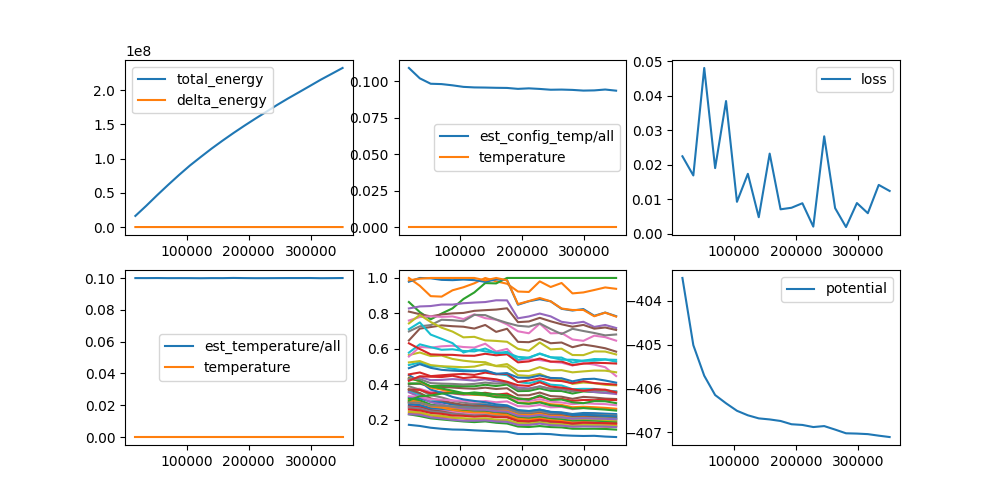

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plot_metric(axes[0, 0], d, 'total_energy')
plot_metric(axes[0, 0], d, 'delta_energy')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'potential')

fig.show()

In [60]:
d['steps'][:]

array([                   0,                    1,                    2,
       ..., -9223372036854775808, -9223372036854775808,
       -9223372036854775808])

# OurHMC metrics

Produced with
```bash
python experiments/train_bnn.py -D with model=test_gaussian warmup=0 \
    burnin=0 n_samples=300 inference=OurHMC momentum=1.0 lr=10.0
```

Note that loss=temperature because we're sampling from a Gaussian.

In [ ]:
d = read_metrics("../logs/57")
d.keys()

In [ ]:
_, axes = plt.subplots(2, 3, figsize=(15, 8))
plot_metric(axes[0, 0], d, 'acceptance/log_prob')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
plot_metric(axes[1, 1], d, 'acceptance/rejected')

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'lr')

# SGLD metrics

Produced with
```bash
python experiments/train_bnn.py -D with model=test_gaussian warmup=0 \
    burnin=0 n_samples=300 inference=SGLD momentum=0.6 lr=10.0
```

In [ ]:
d = read_metrics("../logs/52")
d.keys()

In [ ]:
_, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_metric(axes[0, 0], d, 'est_config_temp/all')
plot_metric(axes[0, 0], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')

plot_metric(axes[0, 1], d, 'loss')
plot_metric(axes[1, 1], d, 'lr')